In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import os
#from skimage.measure import label,regionprops_table
#import pandas as pd
#import open3d as o3d

In [2]:
import subprocess

#subprocess.run(["python", 'code/synthetic_testing/create_syn_shadow.py', '12','1500', '0.1'])
subprocess.run(["python", 'create_syn_shadow.py', '12','1500'])
#subprocess.run(["python", 'code/synthetic_testing/create_syn_shadow.py', '12','1500', '0.3'])
#subprocess.run(["python", 'code/synthetic_testing/create_syn_shadow.py', '12','1500', '0.4'])
subprocess.run(["python", 'create_syn_shadow.py', '12','1500', '0.5'])

CompletedProcess(args=['python', 'create_syn_shadow.py', '12', '1500', '0.5'], returncode=0)

In [3]:
ran_color=True
min_radi=32
image_size=10000
num_circles = 5000
max_radi=3000

if ran_color:
    Dir=f'/DATA/vito/data/ran_synth_{min_radi}_cl_std_000/'
else:
    Dir=f'/DATA/vito/data/ran_synth_{min_radi}_bw/'
if not os.path.exists(Dir[:-1]):
    os.makedirs(Dir[:-1])
    os.makedirs(Dir+'img')
    os.makedirs(Dir+'msk')
    os.makedirs(Dir + 'zht')
for i in range(1):
    image = np.zeros((image_size, image_size, 3), dtype=np.uint8)
    mask = np.zeros((image_size, image_size), dtype=np.uint16)
    height_image = np.zeros((image_size, image_size), dtype=np.float32)

    circles = []

    for circle_id in range(1, num_circles + 1):
        max_attempts = 100  # Limit the number of attempts to find a non-overlapping position
        for attempt in range(max_attempts):
            radius = random.randint(min_radi, max_radi)
            center_x = random.randint(radius, image_size - radius)
            center_y = random.randint(radius, image_size - radius)
            center = (center_x, center_y)

            # Check for overlap with existing circles
            overlap = False
            for (existing_center, existing_radius) in circles:
                dist = np.sqrt((center_x - existing_center[0]) ** 2 + (center_y - existing_center[1]) ** 2)
                if dist < radius + existing_radius + 1:#+1 so that no contact between circles
                    overlap = True
                    break

            if not overlap:
                circles.append((center, radius))
                
                if ran_color:
                    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
                else:
                    color = (255,255,255)
                cv2.circle(image, center, radius, color, -1)
                
                cv2.circle(mask, center, radius, circle_id, -1)
                y1, y2 = center_y - radius, center_y + radius
                
                #DEM
                x1, x2 = center_x - radius, center_x + radius

                if x1 < 0 or y1 < 0 or x2 >= image_size or y2 >= image_size:
                    continue

                yy, xx = np.meshgrid(np.arange(y1, y2), np.arange(x1, x2), indexing='ij')
                dx = xx - center_x
                dy = yy - center_y
                dist_sq = dx**2 + dy**2
                mask_circle = dist_sq <= radius**2

                z = np.zeros_like(dist_sq, dtype=np.float32)
                z[mask_circle] = np.sqrt(radius**2 - dist_sq[mask_circle])

                height_image[y1:y2, x1:x2] = np.maximum(height_image[y1:y2, x1:x2], z)
                break  

    #np.save(Dir+f'img/img_{i:02}',image)
    #np.save(Dir+f'msk/msk_{i:02}',mask)


In [4]:
def cdf(data, title_label, xlabel, label=''):

    data = np.sort(data)
    cdf = np.arange(1, len(data) + 1) / len(data)
    plt.plot(data, cdf, label=label)


    plt.title(title_label, fontsize=20)
    plt.xscale("log")
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel("Cumulative Probability", fontsize=16)        
    plt.grid(True)

In [5]:
def add_gaussian_noise_to_circle(array, mean ,std , mask=None, edge_std=None):
    '''
    add gaussian noise to the input image. if mask is given noise will not be added to the area outside the circle. if edge_std is given, different noise will be applied to the edge. mask is required for that.
    '''
    gaussian_noise = np.random.normal(mean, std, array.shape)
    if np.any(mask):
        mask=mask>0
        gaussian_noise=gaussian_noise*mask[:, :, np.newaxis]
        if edge_std:
            gaussian_noise_ed = np.random.normal(mean, edge_std, array.shape)
            gaussian_noise+=gaussian_noise_ed*~mask[:, :, np.newaxis]
    noisy_image = array.astype(float) + gaussian_noise
    #noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    
    return noisy_image

def compute_hillshade(z, azimuth=315, altitude=45, z_factor=1.0):
    azimuth_rad = np.radians(azimuth)
    altitude_rad = np.radians(altitude)

    dzdx = np.gradient(z, axis=1)
    dzdy = np.gradient(z, axis=0)

    slope_rad = np.arctan(z_factor * np.sqrt(dzdx**2 + dzdy**2))
    aspect_rad = np.arctan2(dzdy, -dzdx)

    shaded = (np.sin(altitude_rad) * np.cos(slope_rad) + np.cos(altitude_rad) * np.sin(slope_rad) * np.cos(azimuth_rad - aspect_rad))

    #shaded = np.clip(shaded, 0, 1)
    #shaded = (shaded * 255).astype(np.uint8)

    return shaded

In [6]:
noisy_height=add_gaussian_noise_to_circle(height_image,0,3)

noisy_height = np.clip(noisy_height, a_min=0,a_max=None)

hillshade = compute_hillshade(noisy_height, azimuth=225, altitude=25)
hillshade = np.clip(hillshade, 0, 1)

hillshade_3ch = np.stack([hillshade]*3, axis=-1)  
image_shadow = (image.astype(np.float32) * hillshade_3ch).astype(np.uint8)

In [7]:
from tqdm import trange
from numba import cuda
from math import sqrt


@cuda.jit("float32[:, :], float32[:, :], int64, int64, int64, float64, float64, float64")
def cuda_kern_cast_shadow(s, z, ys, xs, thr, slope, azim, incl):
    i, j = cuda.grid(2)
    if i < ys and j < xs:
        b = i - slope * j
        aazim = abs(azim)
        klen = 0
        slen = 0
        k = 0
        o = 0
        if 45 <= aazim and aazim <= 135:
            # steep steps, each row one pixel
            if 0 <= azim:
                for y in range(i, ys):
                    x = int((y - b) / slope)
                    if xs <= x:
                        break
                    if x < 0:
                        break
                    dy, dx = y - i, x - j
                    r = sqrt(dx*dx + dy*dy)
                    dz = z[y, x] - z[i, j] - r * incl
                    if dz > 0:
                        if k == o + 1:
                            klen += 1
                        else:
                            klen = 0
                        if klen > slen:
                            slen = klen
                        o = k
                    if slen > thr:
                        break
                    k += 1
            else:
                for y in range(i, 0, -1):
                    x = int((y - b) / slope)
                    if xs <= x:
                        break
                    if x < 0:
                        break
                    dy, dx = y - i, x - j
                    r = sqrt(dx*dx + dy*dy)
                    dz = z[y, x] - z[i, j] - r * incl
                    if dz > 0:
                        if k == o + 1:
                            klen += 1
                        else:
                            klen = 0
                        if klen > slen:
                            slen = klen
                        o = k
                    if slen > thr:
                        break
                    k += 1
        else:
            # shallow steps, each col one pixel
            if abs(azim) <= 90:
                for x in range(j, xs):
                    y = int(slope * x + b)
                    if ys <= y:
                        break
                    if y < 0:
                        break
                    dy, dx = y - i, x - j
                    r = sqrt(dx*dx + dy*dy)
                    dz = z[y, x] - z[i, j] - r * incl
                    if dz > 0:
                        if k == o + 1:
                            klen += 1
                        else:
                            klen = 0
                        if klen > slen:
                            slen = klen
                        o = k
                    if slen > thr:
                        break
                    k += 1
            else:
                for x in range(j, 0, -1):
                    y = int(slope * x + b)
                    if ys <= y:
                        break
                    if y < 0:
                        break
                    dy, dx = y - i, x - j
                    r = sqrt(dx*dx + dy*dy)
                    dz = z[y, x] - z[i, j] - r * incl
                    if dz > 0:
                        if k == o + 1:
                            klen += 1
                        else:
                            klen = 0
                        if klen > slen:
                            slen = klen
                        o = k
                    if slen > thr:
                        break
                    k += 1
        if slen > thr:
            s[i, j] = 1


def cast_shadow(z, azimuth, inclination):
    thr = 5 # minimum light blocking thickness
    assert inclination < 90
    incli = np.tan((90 - inclination) * np.pi / 180)
    slope = np.tan(azimuth * np.pi / 180)
    ys, xs = z.shape
    d_z = cuda.to_device(z.astype("float32"))
    d_s = cuda.device_array((ys, xs), np.float32)
    nthreads = (16, 16)
    nblocksy = ys // nthreads[0] + 1
    nblocksx = xs // nthreads[0] + 1
    nblocks = (nblocksy, nblocksx)
    cuda_kern_cast_shadow[nblocks, nthreads](d_s, d_z, ys, xs, thr, slope, np.float64(azimuth), incli)
    s = d_s.copy_to_host()
    return s

In [22]:
azimuth = 120
inclination = 60
shadow_image = cast_shadow(noisy_height, azimuth, inclination)

In [ ]:
shadow_image-=1
shadow_image=np.abs(shadow_image)

In [ ]:
shadow_image=np.clip(shadow_image,0.2, None)
shadowed_rgb = (image * shadow_image[:, :, np.newaxis]).astype(np.uint8)

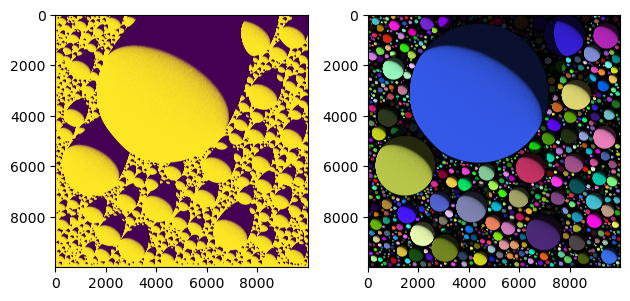

In [24]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(shadow_image)
plt.subplot(1,2,2)
plt.imshow(shadowed_rgb)
plt.tight_layout()

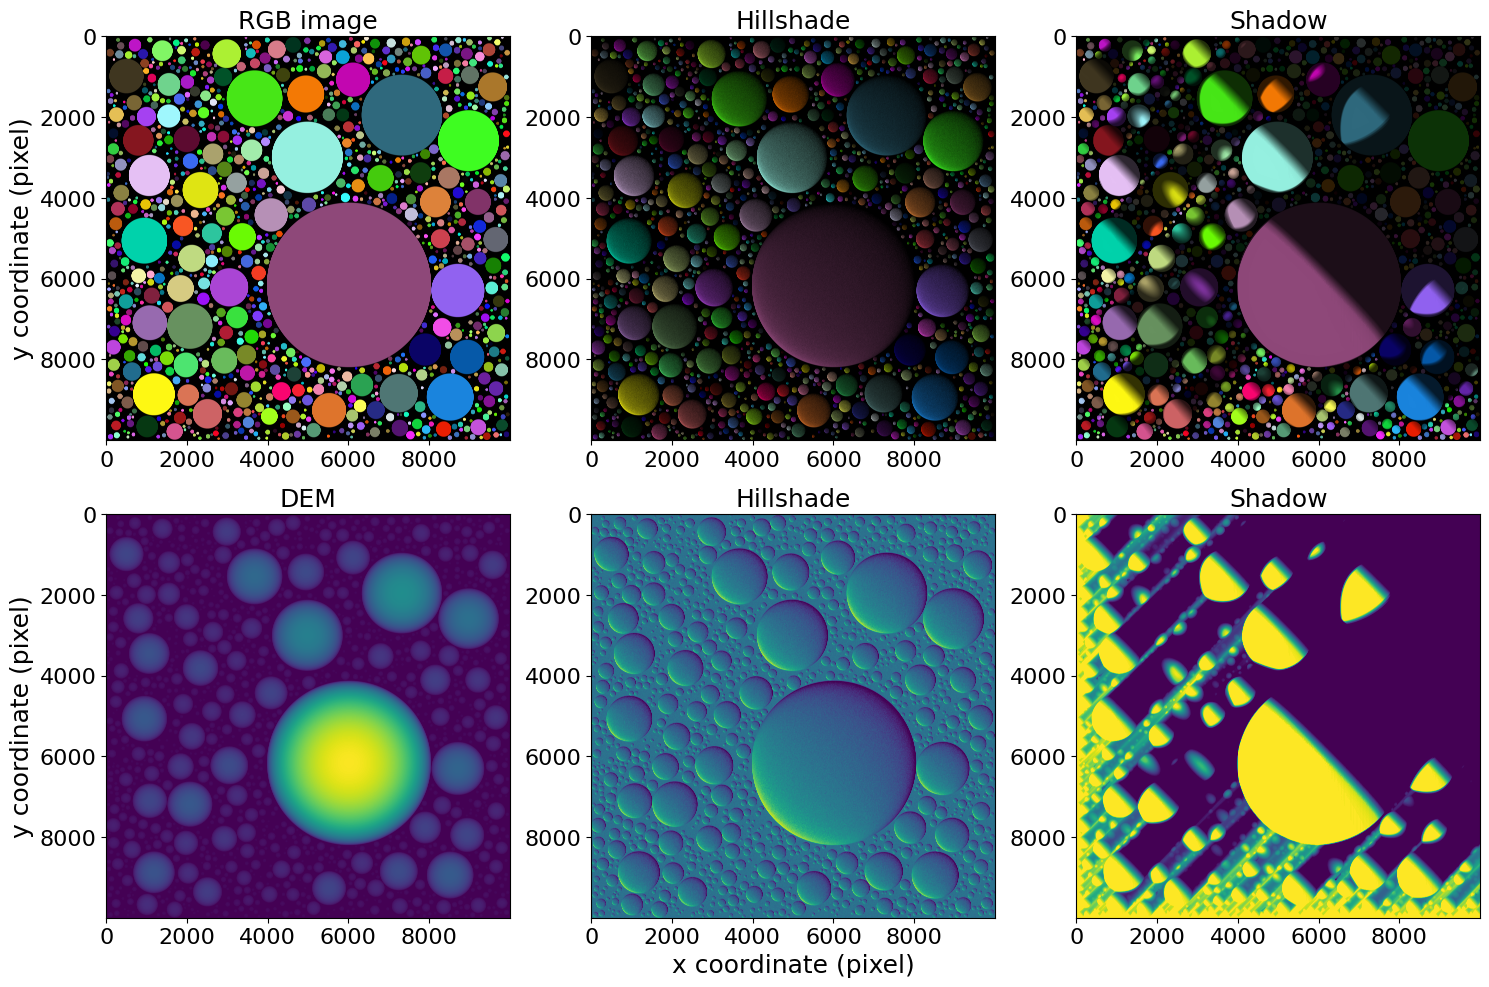

In [66]:
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.imshow(image)
plt.title('RGB image', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("y coordinate (pixel)", fontsize=18)
plt.subplot(2,3,4)
plt.imshow(noisy_height)
plt.title('DEM', fontsize=18)
plt.ylabel("y coordinate (pixel)", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.subplot(2,3,2)
plt.imshow(image_shadow)
#plt.colorbar()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Hillshade', fontsize=18)
plt.subplot(2,3,5)
plt.imshow(hillshade)
#plt.colorbar()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("x coordinate (pixel)", fontsize=18)
plt.title('Hillshade', fontsize=18)
plt.subplot(2,3,3)
plt.imshow(shadowed_rgb)
plt.title('Shadow', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.subplot(2,3,6)
plt.imshow(shadow_mask)
plt.title('Shadow', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
labeled=label(mask, background=0)
props = regionprops_table(
    labeled,
    properties=('axis_major_length', 'area'),
)
props_df=pd.DataFrame(props)

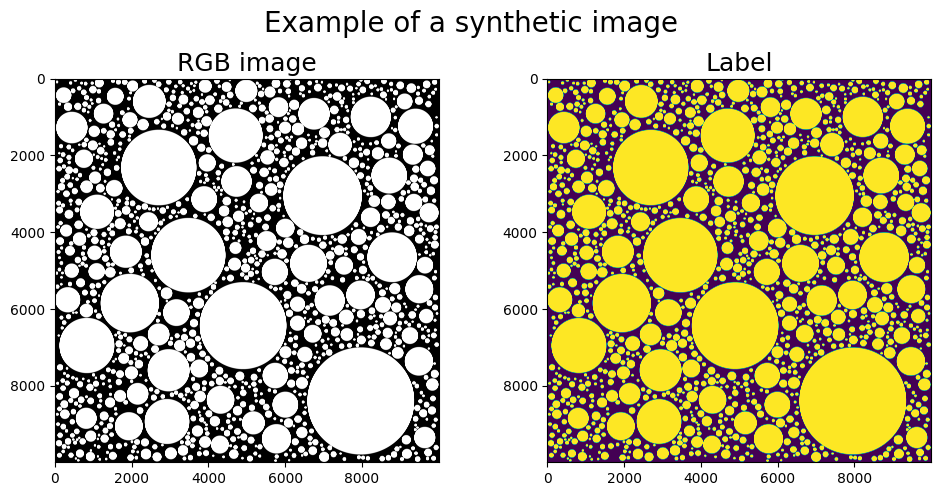

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(image)
#plt.title('RGB image', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("y coordinate (pixel)", fontsize=18)
plt.xlabel("x coordinate (pixel)", fontsize=18)
plt.subplot(1,2,2)
#plt.imshow(mask>0)
#plt.title('Label', fontsize=18)
#plt.subplot(1,2,3)
cdf(props_df['area'], '', 'Area (pixels)',f'Size distribution (n = {len(np.unique(mask)-1)})')
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.suptitle('Example of a synthetic image', fontsize=20)
plt.tight_layout()#rect=[0, 0.03, 1, 0.98])
#plt.savefig('figure/example_syn_img.png')
